In [41]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [42]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [43]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [44]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [45]:
sequences = ['GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY']

In [46]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [47]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['g'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [48]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 5.0, 200, 257, 10]


### Genetic Algorithm

In [49]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [50]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	72   	-875.158	22.1215	-950.288	-844.838
1  	72   	-891.921	18.5536	-950.288	-864.448
2  	82   	-910.837	18.8537	-956    	-884.372
3  	54   	-926.136	16.8117	-969.547	-899.486
4  	71   	-942.04 	11.4054	-969.547	-923.824
5  	76   	-952.325	7.78026	-969.547	-939.366
6  	75   	-959.208	5.4281 	-969.949	-950.889
7  	75   	-964.052	4.57098	-970.033	-957.264
8  	82   	-966.38 	3.74645	-970.033	-959.005
9  	64   	-969.469	0.720516	-970.033	-965.572
10 	54   	-969.863	0.127488	-970.033	-969.547
11 	64   	-969.944	0.0408987	-970.041	-969.848
12 	76   	-969.979	0.0336918	-970.062	-969.937
13 	72   	-969.996	0.030476 	-970.081	-969.949
14 	50   	-970.002	0.02942  	-970.081	-969.959
15 	74   	-970.011	0.0233872	-970.081	-969.974
16 	78   	-970.021	0.0235333	-970.081	-969.983
17 	70   	-970.033	0.0203705	-970.085	-970    
18 	69   	-970.044	0.0167073	-970.095	-970.017
19 	82   	-970.049	0.0165314	-970.095	-970.025
20 	72   	-970.054	0.0159023	-970.0

In [51]:
optimized_model_ga = opt_ga.best_model

In [52]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-972.8577500018744

In [53]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [54]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

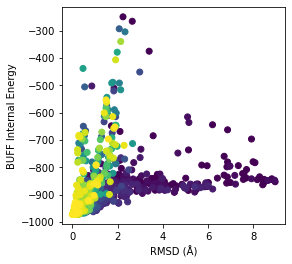

In [55]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [56]:
f = open('d_CC-Di_ap-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [57]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [58]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-868.068	47.8607	-938.478	-570.256
1  	100  	-880.974	32.8344	-942.184	-684.409
2  	100  	-895.36 	25.8332	-958.253	-846.076
3  	100  	-906.694	25.556 	-958.253	-849.787
4  	100  	-914.784	23.7285	-958.253	-864.22 
5  	100  	-925.431	21.7   	-964.532	-875.117
6  	100  	-933.804	16.6711	-969.275	-894.09 
7  	100  	-940.026	14.2405	-969.275	-902.09 
8  	100  	-947.608	12.8273	-978.391	-921.45 
9  	100  	-952.729	12.0857	-978.391	-924.001
10 	100  	-957.694	9.1612 	-978.391	-931.804
11 	100  	-961.57 	7.75583	-982.567	-944.406
12 	100  	-964.575	6.96366	-982.567	-945.531
13 	100  	-967.277	6.13364	-982.567	-952.149
14 	100  	-969.573	5.57466	-982.567	-953.049
15 	100  	-971.547	4.6866 	-982.567	-958.856
16 	100  	-973.829	5.01216	-984.816	-958.856
17 	100  	-976    	4.22033	-984.816	-967.103
18 	100  	-977.361	3.8087 	-984.816	-967.531
19 	100  	-978.669	3.40673	-984.816	-970.608
20 	100  	-980.073	3.03345	-985.219	-971.381
21 	100  	

In [59]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-986.8197096898348

In [60]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [61]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

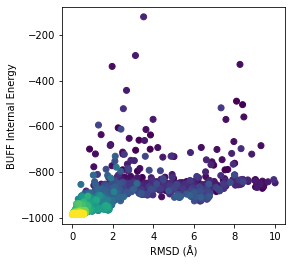

In [62]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [63]:
f = open('d_CC-Di_ap-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [64]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Swarm' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [65]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-834.767	114.947	-935.367	-290.534
1  	89   	-845.873	108.769	-939.454	-200.48 
2  	68   	-854.24 	108.187	-969.021	-200.48 
3  	83   	-850.248	77.249 	-939.903	-462.125
4  	92   	-843.204	78.5602	-940.386	-387.996
5  	89   	-827.722	134.245	-959.806	-257.881
6  	66   	-817.267	122.053	-952.818	-257.881
7  	73   	-781.943	164.123	-953.841	-145.609
8  	81   	-828.851	129.988	-934.747	-145.609
9  	69   	-831.99 	101.05 	-924.968	-309.848
10 	83   	-829.719	108.974	-956.585	-289.966
11 	85   	-863.294	69.8774	-956.585	-565.27 
12 	76   	-874.005	43.8546	-956.585	-615.189
13 	66   	-870.785	39.0341	-956.585	-654.466
14 	84   	-865.525	56.7986	-963.692	-564.009
15 	89   	-786.484	123.506	-963.692	-338.916
16 	86   	-786.938	107.584	-921.526	-338.916
17 	78   	-804.67 	135.751	-944.892	-230.426
18 	81   	-868.518	51.5375	-931.473	-536.826
19 	67   	-820.737	139.961	-941.814	-95.0463
20 	56   	-831.649	143.91 	-957.124	-95.0463
21 	74   	

In [66]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-969.0213745034636

In [67]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [68]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

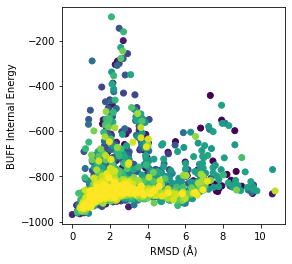

In [69]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [70]:
f = open('d_CC-Di_ap-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [71]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [72]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-855.433	36.4819	-926.844	-676.67
1  	100  	-870.066	17.3405	-898.525	-813.206
2  	100  	-865.655	24.8218	-902.322	-718.319
3  	100  	-868.582	20.6718	-899.803	-803.616
4  	100  	-866.846	20.6244	-904.331	-799.295
5  	100  	-867.786	24.6774	-909.704	-757.263
6  	100  	-864.199	38.3379	-915.833	-596.661
7  	100  	-868.502	27.4778	-918.245	-711.682
8  	100  	-874.98 	25.146 	-916.16 	-757.441
9  	100  	-876.137	29.0812	-935.332	-774.129
10 	100  	-868.45 	45.8466	-927.781	-659.91 
11 	100  	-877.784	62.3906	-942.257	-469.349
12 	100  	-854.043	86.569 	-948.544	-537.692
13 	100  	-874.443	59.974 	-953.728	-547.92 
14 	100  	-885.012	69.763 	-968.343	-604.477
15 	100  	-893.014	79.1834	-973.718	-356.281
16 	100  	-925.038	50.4203	-982.755	-580.011
17 	100  	-948.757	23.3153	-980.066	-858.968
18 	100  	-961.233	13.307 	-979.962	-903.561
19 	100  	-968.854	11.3585	-984.337	-889.738
20 	100  	-973.355	10.0801	-985.078	-924.411
21 	100  	-9

In [73]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-986.7225668300273

In [74]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [75]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

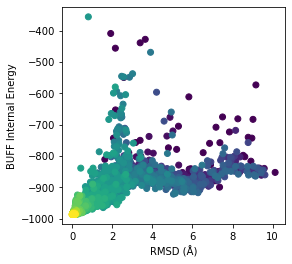

In [76]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [77]:
f = open('d_CC-Di_ap-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)